In [1]:
import numpy as np
import numpy.lib.stride_tricks
import math
from matplotlib import pyplot as plt

In [2]:
u = np.zeros((2,2,10))
w = np.zeros((1,2,10))
print(u)
print(w)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]


In [3]:
#Custom Functions

#Trapezoid Integration Function
def integrate(u,dx,x_vals):
    area_under_curve = 0
    for i in range(0,len(x_vals)-1):
        area = dx * (u[i+1]+u[i]) / 2
        area_under_curve = area_under_curve + area
    return area_under_curve

#Gaussian Function
def gaussian(x, mu, sigma):
    denom = sigma * ((2 * math.pi)**0.5)
    numerator = math.exp(((x - mu)**2) / ((sigma) **2) / -2)
    res = numerator / denom
    return res

# Habitat Preference
def preference(x):
    pi = math.pi
    res = -math.cos(pi*x/5) + 1.1 
    res = np.float64(res)
    return res

# 1st Derivative of Habitat Preference Function
def preference_slope(x):
    pi = math.pi
    res = pi/5*math.sin(pi*x/5)
    res = np.float64(res)
    return res

# 2nd Derivative of Habitat Preference Function
def preference_slope_slope(x):
    pi = math.pi
    res = (2*pi*pi/625) * math.cos(2*pi*x/25)# Example 1
    res = -0.02 * ((-0.02 * math.exp(-0.01*(x-50)**2)*(x-50))*(x-50)+1*math.exp(-0.01*(x-50)**2)) # Example 2
    res = np.float64(res)
    return res

#Normalized RMSE

def rmse(model, true, nx, t):
    summation = 0
    for i in range(0,nx):
        dif = (model[t][1][i] - true[0][1][i])**2
        summation = summation + dif
    rmse = (summation/nx)**0.5
    return abs(rmse)

#Convergence Flag

def converge(current_t, t_minus1000, t_minus2000):
    #function to determine whether finite difference scheme has convered
    #inputs are rows of an array
    current_t = np.float128(current_t ** 0.01)
    t_minus50 = np.float128(t_minus1000 ** 0.01)
    t_minus100 = np.float128(t_minus2000 ** 0.01)
    h1 = abs(t_minus1000 - t_minus2000)
    print(h1)
    h2 = abs(current_t - t_minus1000)
    print(h2)
    dif = abs(h1-h2)
    print(dif)
    cuttoff = np.format_float_scientific(np.float128(1e-128), unique=False, precision=128)
    mask = dif>np.float128(cuttoff)
    print(mask)
    if True not in mask:
        print("yes")
        return True
    
#Sliding window
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
        
    

In [4]:
#Model Settings

# Initializing x values where u(x,t) will be calculated
dx = 1  # delta x
Xs = np.arange(0, 11, dx)

# Bounds
start = Xs[0] # start bound
stop = Xs[-1]# stop bound


# Model parameters
dt = 1 # delta t
T = 2 # Total time
Nt = int(T / dt)  # Number of time steps
Nx = int((abs(stop-start))/dx)  # Number of x steps
mean_sl = 0.04 #mean step length
k = (mean_sl**2)/2/dt # diffusion coefficient equal to mean step length squared
r = k * dt / dx / dx  # Fourier number

# Fourier Number Flag
if r > 0.5:
    print("Fourier Number " + str(r) +  " > 0.5. Adjust mean step length, dx, or dt")

In [5]:
# Initializing x values where u(x,t) will be calculated
Xs = np.arange(0, 11, dx)

# Initializing array with Nt row, Nx columns, and [x,u(x,t)] per cell
u = np.zeros((2, 2, len(Xs)))

#Habitat Preference Function
w = np.zeros((1,2,len(Xs)))
w[0][0] = Xs
for i in range(0,len(Xs)):
    w[0][1][i] = preference(w[0][0][i])
print("w:")
print(w)

#First Spatial Derivative of Habitat Preference Function
wx = np.zeros((1,2,len(Xs)))
wx[0][0] = Xs
for i in range(0,len(Xs)):
    wx[0][1][i] = preference_slope(w[0][0][i])
print("wx:")
print(wx)


#Second Spatial Derivative of Habitat Preference Function
wxx = np.zeros((1,2,len(Xs)))
wxx[0][0] = Xs
for i in range(0,len(Xs)):
    wxx[0][1][i] = preference_slope_slope(w[0][0][i])
print("wxx:")
print(wxx)

#Velocity
c = np.zeros((1,2,len(Xs)))
c[0][0] = Xs
for i in range(0,len(Xs)):
    c[0][1][i] = ((mean_sl**2)/dt)*(wx[0][1][i]/w[0][1][i])
print("c:")
print(c)
    
#First derivative of veloctiy
cx = np.zeros((1,2,len(Xs)))
cx[0][0] = Xs
for i in range(0,len(Xs)):
    numerator = (wxx[0][1][i] * w[0][1][i]) - (wx[0][1][i]**2)
    denom = w[0][1][i]**2
    cx[0][1][i] = ((mean_sl**2)/dt)* numerator / denom
print("cx:")
print(cx)

# Populating x values in array u
for j in range(0, 2):
    u[j][0]=Xs
    
# Setting Initial Condition
IC=[1,2,3,4,5,6,5,4,3,2,1]
u[0][1] = IC # Populating initial condition in array u

print("u:")
print(u)

w:
[[[ 0.          1.          2.          3.          4.
    5.          6.          7.          8.          9.
   10.        ]
  [ 0.1         0.29098301  0.79098301  1.40901699  1.90901699
    2.1         1.90901699  1.40901699  0.79098301  0.29098301
    0.1       ]]]
wx:
[[[ 0.00000000e+00  1.00000000e+00  2.00000000e+00  3.00000000e+00
    4.00000000e+00  5.00000000e+00  6.00000000e+00  7.00000000e+00
    8.00000000e+00  9.00000000e+00  1.00000000e+01]
  [ 0.00000000e+00  3.69316366e-01  5.97566433e-01  5.97566433e-01
    3.69316366e-01  7.69468277e-17 -3.69316366e-01 -5.97566433e-01
   -5.97566433e-01 -3.69316366e-01 -1.53893655e-16]]]
wxx:
[[[0.00000000e+00 1.00000000e+00 2.00000000e+00 3.00000000e+00
   4.00000000e+00 5.00000000e+00 6.00000000e+00 7.00000000e+00
   8.00000000e+00 9.00000000e+00 1.00000000e+01]
  [1.36101850e-11 3.51481208e-11 8.88933023e-11 2.20164619e-10
   5.33972722e-10 1.26813016e-09 2.94890315e-09 6.71407494e-09
   1.49663586e-08 3.26605664e-08 6.97718083

In [6]:
c_win = rolling_window(c[0][1],3)
u_win = rolling_window(u[0][1],3)
a = c_win * u_win

print("c_win:")
print(c_win)
print("u_win:")
print(u_win)
print("a:")
print(a)

#Coefs from finite difference
advec_multipliers_cd = np.array([-1,0,1])
#Coefs from finite difference
advec_multipliers_posc = np.array([1,-4,3])
#Coefs from finite difference
advec_multipliers_negc = np.array([-3,4,-1])
#Coefs from finite difference
diffusion_multipliers = np.array([1,-2,1])

c_win:
[[ 0.00000000e+00  2.03072404e-03  1.20875706e-03]
 [ 2.03072404e-03  1.20875706e-03  6.78562641e-04]
 [ 1.20875706e-03  6.78562641e-04  3.09534272e-04]
 [ 6.78562641e-04  3.09534272e-04  5.86261545e-20]
 [ 3.09534272e-04  5.86261545e-20 -3.09534272e-04]
 [ 5.86261545e-20 -3.09534272e-04 -6.78562641e-04]
 [-3.09534272e-04 -6.78562641e-04 -1.20875706e-03]
 [-6.78562641e-04 -1.20875706e-03 -2.03072404e-03]
 [-1.20875706e-03 -2.03072404e-03 -2.46229849e-18]]
u_win:
[[1. 2. 3.]
 [2. 3. 4.]
 [3. 4. 5.]
 [4. 5. 6.]
 [5. 6. 5.]
 [6. 5. 4.]
 [5. 4. 3.]
 [4. 3. 2.]
 [3. 2. 1.]]
a:
[[ 0.00000000e+00  4.06144809e-03  3.62627118e-03]
 [ 4.06144809e-03  3.62627118e-03  2.71425056e-03]
 [ 3.62627118e-03  2.71425056e-03  1.54767136e-03]
 [ 2.71425056e-03  1.54767136e-03  3.51756927e-19]
 [ 1.54767136e-03  3.51756927e-19 -1.54767136e-03]
 [ 3.51756927e-19 -1.54767136e-03 -2.71425056e-03]
 [-1.54767136e-03 -2.71425056e-03 -3.62627118e-03]
 [-2.71425056e-03 -3.62627118e-03 -4.06144809e-03]
 [-3.6

In [7]:
#c > 0 upwind

#Calculating Advection
advec_broad_posc = np.broadcast(a, advec_multipliers_posc)
advec_posc = np.empty(advec_broad_posc.shape)
advec_posc.flat = [u*v/(2*dx) for (u,v) in advec_broad_posc]
advec_sum_posc = np.sum(advec_posc, axis = 1)
advec_posc = numpy.append([0,0],advec_sum_posc)

print("advec_posc:")
print(advec_posc)

advec_posc:
[ 0.          0.         -0.00268349 -0.00115044 -0.00129386 -0.00173822
 -0.00154767 -0.00097603 -0.00078474 -0.00019676  0.00630976]


In [8]:
#c < 0 upwind

#Calculating Advection
advec_broad_negc = np.broadcast(a, advec_multipliers_negc)
advec_negc = np.empty(advec_broad_negc.shape)
advec_negc.flat = [u*v/(2*dx) for (u,v) in advec_broad_negc]
advec_sum_negc = np.sum(advec_negc, axis = 1)
advec_negc = numpy.append(advec_sum_negc,[0,0])

print("advec_negc:")
print(advec_negc)

advec_negc:
[ 0.00630976 -0.00019676 -0.00078474 -0.00097603 -0.00154767 -0.00173822
 -0.00129386 -0.00115044 -0.00268349  0.          0.        ]


In [9]:
# c central dif

#Calculating Advection
advec_broad_cd = np.broadcast(a, advec_multipliers_cd)
advec_cd = np.empty(advec_broad_cd.shape)
advec_cd.flat = [u*v/(2*dx) for (u,v) in advec_broad_cd]
advec_sum_cd = np.sum(advec_cd, axis = 1)
advec_cd1 = np.append([0], advec_sum_cd)
advec_cd = np.append(advec_cd1,[0])

print("advec_cd:")
print(advec_cd)

advec_cd:
[ 0.          0.00181314 -0.0006736  -0.0010393  -0.00135713 -0.00154767
 -0.00135713 -0.0010393  -0.0006736   0.00181314  0.        ]


In [10]:
#assigning advection scheme
#1 = c>0
#0 = central difference
#-1 = c<0

csign_win = np.where(c_win < 0, -1,np.where(c_win>0,1,0))

posc_check1 = np.all(csign_win == 1, axis = 1)
posc_check = np.append([False,False],posc_check1)

negc_check1 = np.all(csign_win == -1, axis = 1)
negc_check = np.append(negc_check1, [False,False])

cd_check = np.where(negc_check == posc_check, True, False)
cd_check[0] = False
cd_check[-1] = False

advec_scheme = np.full((1,len(Xs)),-99)
advec_scheme = np.where(posc_check == True,1,
                        np.where(negc_check == True,-1,
                                 np.where(cd_check == True, 0, advec_scheme[0][1])))

advection = np.zeros((1,len(Xs)))
advection = np.where(advec_scheme == 1, advec_posc, 
                           np.where(advec_scheme == 0, advec_cd,
                                   np.where(advec_scheme == -1, advec_negc, -99)))
print("c_win:")
print(c_win)
print("csign_win:")
print(csign_win)
print("posc_check:")
print(posc_check)
print("negc_check:")
print(negc_check)
print("cd_check:")
print(cd_check)
print("csign:")
print(np.where(c[0][1]<0,-1,np.where(c[0][1]>0,1,0)))
print("advec_scheme:")
print(advec_scheme)

c_win:
[[ 0.00000000e+00  2.03072404e-03  1.20875706e-03]
 [ 2.03072404e-03  1.20875706e-03  6.78562641e-04]
 [ 1.20875706e-03  6.78562641e-04  3.09534272e-04]
 [ 6.78562641e-04  3.09534272e-04  5.86261545e-20]
 [ 3.09534272e-04  5.86261545e-20 -3.09534272e-04]
 [ 5.86261545e-20 -3.09534272e-04 -6.78562641e-04]
 [-3.09534272e-04 -6.78562641e-04 -1.20875706e-03]
 [-6.78562641e-04 -1.20875706e-03 -2.03072404e-03]
 [-1.20875706e-03 -2.03072404e-03 -2.46229849e-18]]
csign_win:
[[ 0  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1 -1]
 [ 1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
posc_check:
[False False False  True  True  True False False False False False]
negc_check:
[False False False False False False  True  True  True False False]
cd_check:
[False  True  True False False False False False False  True False]
csign:
[ 0  1  1  1  1  1 -1 -1 -1 -1 -1]
advec_scheme:
[-99   0   0   1   1   1  -1  -1  -1   0 -99]


In [11]:
#Calculate advection manually at edges
csign = np.where(c[0][1] < 0, -1,np.where(c[0][1]>0,1,0))

#Left Edge
backward_csign = np.array([csign[0],csign[-1], csign[-2]])
if advection[0] == -99 and sum(backward_csign) == 3:
    backward_u = np.array([u[0][1][-2], u[0][1][-1], u[0][1][0]])
    backward_c = np.array([c[0][1][-2], c[0][1][-1], c[0][1][0]])
    advec = backward_c * advec_multipliers_posc * backward_u * (1/(2*dx))
    advec_sum = sum(advec)
    advection[0] = advec_sum
else:
    center_left_u = np.array([u[0][1][-1], u[0][1][0], u[0][1][1]])
    center_left_c = np.array([c[0][1][-1], c[0][1][0], c[0][1][1]])
    advec = center_left_u * center_left_c * advec_multipliers_cd * (1/(2*dx))
    advec_sum = sum(advec)
    advection[0] = advec_sum
                           
#Right Edge
forward_csign = np.array([csign[-1],csign[0], csign[1]])
if advection[-1] == -99 and sum(forward_csign) == -3:
    forward_u = np.array([u[0][1][-1], u[0][1][0], u[0][1][1]])
    forward_c =  np.array([c[0][1][-1], c[0][1][0], c[0][1][1]])
    advec = forward_c * advec_multipliers_negc * forward_u * (1/(2*dx))
    advec_sum = sum(advec)
    advection[-1] = advec_sum
else:
    center_right_u = np.array([u[0][1][-2], u[0][1][-1], u[0][1][0]])
    center_right_c = np.array([c[0][1][-2], c[0][1][-1], c[0][1][0]])
    advec = center_right_u * center_right_c * advec_multipliers_cd * (1/(2*dx))
    advec_sum = sum(advec)
    advection[-1] = advec_sum


In [12]:
#Adding c'(i) * u(i,j) to advection term
advection = advection + (u[0][1] * cx[0][1])
print(advection)

[ 0.00203072 -0.00334166 -0.00341315 -0.00230156 -0.00159327 -0.00173822
 -0.00159327 -0.00230156 -0.00542304 -0.00334166  0.00203073]


In [13]:
#Calculating Diffusion
dif_broad = np.broadcast(u_win,diffusion_multipliers)
dif = np.empty(dif_broad.shape)
dif.flat = [u*v/(dx**2) for (u,v) in dif_broad]
dif_sum = np.sum(dif, axis = 1)
dif1 = np.append([0], dif_sum)
diffusion = np.append(dif1, [0])

In [14]:
print(u[0])

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  5.  4.  3.  2.  1.]]


In [15]:
#Calculaing Diffusion manually at edges
center_left_u = np.array([u[0][1][-1], u[0][1][0], u[0][1][1]])
dif_left = center_left_u * diffusion_multipliers * (1/(dx**2))
dif_left_sum = sum(dif_left)
diffusion[0] = dif_left_sum

center_right_u = np.array([u[0][1][-2], u[0][1][-1], u[0][1][0]])
dif_right = center_right_u * diffusion_multipliers * (1/(dx**2))
dif_right_sum = sum(dif_right)
diffusion[-1] = dif_right_sum

#multiplying by diffusion constant
diffusion = diffusion * k
print("diffusion:")
print(diffusion)

diffusion:
[ 0.0008  0.      0.      0.      0.     -0.0016  0.      0.      0.
  0.      0.0008]


In [16]:
#calculating u at time (j+1)
u[1][1] = u[0][1] + diffusion-advection

#Normalizing by area under curve
area = integrate(u = u[1][1],
                dx = dx,
                x_vals = Xs)

u[1][1] = u[1][1]/area

print("u[j+1]:")
print(u[1])

u[j+1]:
[[ 0.          1.          2.          3.          4.          5.
   6.          7.          8.          9.         10.        ]
 [ 0.02851816  0.05720202  0.08575737  0.11427893  0.14281201  0.17132377
   0.14281201  0.11427893  0.08581476  0.05720202  0.02851816]]


In [17]:
print("IC:")
print(u[0])
print("u[j+1]:")
print(u[1])

IC:
[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
 [ 1.  2.  3.  4.  5.  6.  5.  4.  3.  2.  1.]]
u[j+1]:
[[ 0.          1.          2.          3.          4.          5.
   6.          7.          8.          9.         10.        ]
 [ 0.02851816  0.05720202  0.08575737  0.11427893  0.14281201  0.17132377
   0.14281201  0.11427893  0.08581476  0.05720202  0.02851816]]


<function matplotlib.pyplot.show(close=None, block=None)>

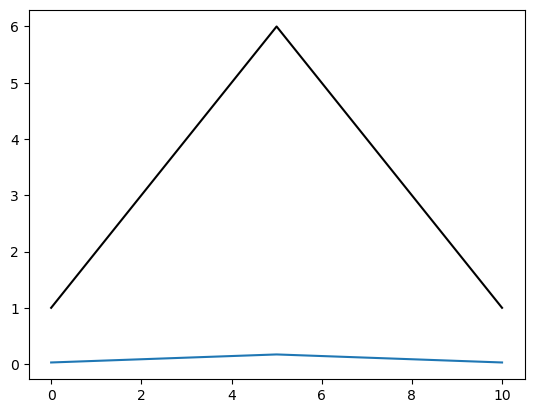

In [18]:
plt.plot(Xs, u[0][1], color = "black")
plt.plot(Xs, u[1][1])

plt.show

In [19]:
#calcultions using old scheme for comparison
# Initializing array with Nt row, Nx columns, and [x,u(x,t)] per cell
u_check = np.zeros((2, 2, len(Xs)))


# Populating x values in array u
for j in range(0, 2):
    u_check[j][0]=Xs
    
# Setting Initial Condition
IC=[1,2,3,4,5,6,5,4,3,2,1]
u_check[0][1] = IC # Populating initial condition in array u


for j in range(0,Nt-1):
    for i in range(0,Nx+1):
        print(i)   
        #Defining velocity at u[i], u[i-1], u[i-2],u[i+1],and u[i+2]
        
        c_x = (mean_sl**2) * wx[0][1][i] / w[0][1][i] / dt 
        cx_x = (mean_sl**2)/dt * (wxx[0][1][i]*w[0][1][i]-wx[0][1][i]**2) / (w[0][1][i]**2)
  
        if i == 0:
            
            c_xminus1 = (mean_sl**2) * wx[0][1][-1] / w[0][1][-1] / dt
            c_xminus2 = (mean_sl**2) * wx[0][1][-2] / w[0][1][-2] / dt
            
        elif i == 1:
            
            c_xminus1 = (mean_sl ** 2) * wx[0][1][0] / w[0][1][0] / dt
            c_xminus2 = (mean_sl ** 2) * wx[0][1][-1] / w[0][1][-1] / dt
            
        else:
            
            c_xminus1 = (mean_sl ** 2) * wx[0][1][i-1] / w[0][1][i-1] / dt
            c_xminus2 = (mean_sl ** 2) * wx[0][1][i-2] / w[0][1][i-2] / dt
            
        if i == Nx:
            
            c_xplus1 = (mean_sl**2) * wx[0][1][0] / w[0][1][0] / dt
            c_xplus2 = (mean_sl**2) * wx[0][1][1] / w[0][1][1] / dt
            
        elif i == (Nx - 1):
            
            c_xplus1 = (mean_sl ** 2) * wx[0][1][-1] / w[0][1][-1] / dt
            c_xplus2 = (mean_sl ** 2) * wx[0][1][0] / w[0][1][0] / dt
            
        else:
            
            c_xplus1 = (mean_sl ** 2) * wx[0][1][i+1] / w[0][1][i+1] / dt
            c_xplus2 = (mean_sl ** 2) * wx[0][1][i+2] / w[0][1][i+2] / dt
  
        
        #Calcutlting u(x) at future timesteps
        
        
        if c_x > 0 and c_xminus1 > 0 and c_xminus2 > 0:
            if i == 0:
                
                diffusion = r * (u_check[j][1][i + 1] - 2 * u_check[j][1][i] + u_check[j][1][Nx])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(3* c_x * u_check[j][1][i] - 
                                                                     4 * c_xminus1 * u_check[j][1][Nx] + 
                                                                     c_xminus2 * u_check[j][1][Nx-1]))
               
                
                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection
                
            elif i == 1:
                
                diffusion = r * (u_check[j][1][i + 1] - 2 * u_check[j][1][i] + u_check[j][1][i - 1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(3* c_x * u_check[j][1][i] - 
                                                                     4 * c_xminus1 * u_check[j][1][i-1] + 
                                                                     c_xminus2 * u_check[j][1][Nx]))
                
                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection
            
            elif i == Nx:
                diffusion = r * (u_check[j][1][0] - 2 * u_check[j][1][i] + u_check[j][1][i - 1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(3* c_x * u_check[j][1][i] - 
                                                                     4 * c_xminus1 * u_check[j][1][i-1] + 
                                                                     c_xminus2 * u_check[j][1][i-2])) 
                
                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection 
            else:
                
                diffusion = r * (u_check[j][1][i + 1] - 2 * u_check[j][1][i] + u_check[j][1][i - 1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(3* c_x * u_check[j][1][i] - 
                                                                     4 * c_xminus1 * u_check[j][1][i-1] + 
                                                                     c_xminus2 * u_check[j][1][i-2])) 
                
                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection 
        
        elif c_x < 0 and c_xplus1 < 0 and c_xplus2 < 0:
            if i == Nx:
                
                diffusion = r * (u_check[j][1][0] - 2 * u_check[j][1][i] + u_check[j][1][i - 1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(-c_xplus2 * u_check[j][1][1] +
                                                                     4 * c_xplus1 * u_check[j][1][0] - 
                                                                     3 * c_x * u_check[j][1][i])) 
               
                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection
                
            elif i == (Nx-1):
                
                diffusion = r * (u_check[j][1][i + 1] - 2 * u_check[j][1][i] + u_check[j][1][i - 1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(-c_xplus2 * u_check[j][1][0] +
                                                                     4 * c_xplus1 * u_check[j][1][i+1] - 
                                                                     3 * c_x * u_check[j][1][i]))
                
                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection 
           
            else:
                
                diffusion = r * (u_check[j][1][i + 1] - 2 * u_check[j][1][i] + u_check[j][1][i - 1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(-c_xplus2 * u_check[j][1][i+2] 
                                                                     +4 * c_xplus1 * u_check[j][1][i+1] - 
                                                                     3 * c_x * u_check[j][1][i]))
                
                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection 
       
        else:
            if i == 0:
                diffusion = r * (u_check[j][1][i + 1] - 2 * u_check[j][1][i] + u_check[j][1][-1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(c_xplus1 * u_check[j][1][i + 1] -
                                                                     c_xminus1 * u_check[j][1][-1]))

                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection 

            elif i == Nx:

                diffusion = r * (u_check[j][1][0] - 2 * u_check[j][1][i] + u_check[j][1][i - 1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(c_xplus1 * u_check[j][1][0] - 
                                                                     c_xminus1 * u_check[j][1][i-1]))

                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection 

            else:

                diffusion = r * (u_check[j][1][i + 1] - 2 * u_check[j][1][i] + u_check[j][1][i - 1])
                advection = -dt*(cx_x*u_check[j][1][i] + (1/(2*dx))*(c_xplus1 * u_check[j][1][i+1] - 
                                                                     c_xminus1 * u_check[j][1][i-1]))

                u_check[j + 1][1][i] = u_check[j][1][i] + diffusion + advection 

        print(i)
        print(advection)
        print(diffusion)
        print(u_check[j+1][1][i])
    area = integrate(u = u_check[j + 1][1],
                     dx = dx,
                     x_vals = Xs)
    u_check[j+1][1] = u_check[j+1][1]/area


    


0
0
-0.002030724043663658
0.0008
0.9987692759563362
1
1
0.0033416645847780158
0.0
2.003341664584778
2
2
0.0034131493195066736
0.0
3.0034131493195066
3
3
0.0023015606168137496
0.0
4.0023015606168135
4
4
0.001593269323339068
0.0
5.001593269323339
5
5
0.0017382174333634714
-0.0016
6.0001382174333635
6
6
0.0015932693132189664
0.0
5.001593269313219
7
7
0.002301560587317281
0.0
4.002301560587317
8
8
0.005423039869412569
0.0
3.0054230398694126
9
9
0.003341664225989577
0.0
2.0033416642259896
10
10
-0.0020307251597948264
0.0008
0.9987692748402051


In [20]:
print(advection)
print(diffusion)

-0.0020307251597948264
0.0008


In [21]:
u_check

array([[[ 0.        ,  1.        ,  2.        ,  3.        ,
          4.        ,  5.        ,  6.        ,  7.        ,
          8.        ,  9.        , 10.        ],
        [ 1.        ,  2.        ,  3.        ,  4.        ,
          5.        ,  6.        ,  5.        ,  4.        ,
          3.        ,  2.        ,  1.        ]],

       [[ 0.        ,  1.        ,  2.        ,  3.        ,
          4.        ,  5.        ,  6.        ,  7.        ,
          8.        ,  9.        , 10.        ],
        [ 0.02851816,  0.05720202,  0.08575737,  0.11427893,
          0.14281201,  0.17132377,  0.14281201,  0.11427893,
          0.08581476,  0.05720202,  0.02851816]]])

In [22]:
print("u_check:")
print(u_check)

print("u:")
print(u)

u_check:
[[[ 0.          1.          2.          3.          4.
    5.          6.          7.          8.          9.
   10.        ]
  [ 1.          2.          3.          4.          5.
    6.          5.          4.          3.          2.
    1.        ]]

 [[ 0.          1.          2.          3.          4.
    5.          6.          7.          8.          9.
   10.        ]
  [ 0.02851816  0.05720202  0.08575737  0.11427893  0.14281201
    0.17132377  0.14281201  0.11427893  0.08581476  0.05720202
    0.02851816]]]
u:
[[[ 0.          1.          2.          3.          4.
    5.          6.          7.          8.          9.
   10.        ]
  [ 1.          2.          3.          4.          5.
    6.          5.          4.          3.          2.
    1.        ]]

 [[ 0.          1.          2.          3.          4.
    5.          6.          7.          8.          9.
   10.        ]
  [ 0.02851816  0.05720202  0.08575737  0.11427893  0.14281201
    0.17132377  0.142